In [1]:
import csv
import json
import os.path

import librosa
import numpy as np
import pandas as pd
from bidict import bidict
from matplotlib import pyplot as plt
import python_speech_features
from scipy.io import wavfile



from scipy.signal import spectrogram

from utils.instrument_data import DataPreprocessor

#### Load Config

In [2]:
with open("../config.json") as json_data_file:
    general_config = json.load(json_data_file)

dataset_path = general_config["IRMAS_Training_Path_Alt"]

CLASS_DICTIONARY = bidict({
    0 : "cel",
    1 : "cla",
    2 : "flu",
    3 : "gac",
    4 : "gel",
    5 : "org",
    6 : "pia",
    7 : "sax",
    8 : "tru",
    9 : "vio",
    10 : "voi"
})

#### Create Dataframe and check Class Distribution

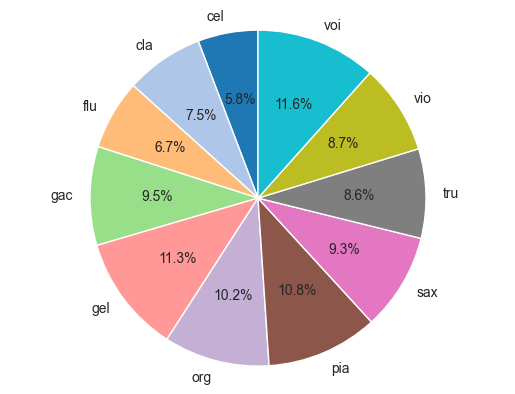

Index(['cel\008__[cel][nod][cla]0058__1.wav',
       'cel\008__[cel][nod][cla]0058__2.wav',
       'cel\008__[cel][nod][cla]0058__3.wav',
       'cel\012__[cel][nod][cla]0043__1.wav',
       'cel\012__[cel][nod][cla]0043__2.wav',
       'cel\012__[cel][nod][cla]0043__3.wav',
       'cel\013__[cel][nod][cla]0025__1.wav',
       'cel\013__[cel][nod][cla]0025__2.wav',
       'cel\013__[cel][nod][cla]0025__3.wav',
       'cel\014__[cel][nod][cla]0041__1.wav',
       ...
       'voi\[voi][pop_roc]2545__3.wav', 'voi\[voi][pop_roc]2546__1.wav',
       'voi\[voi][pop_roc]2546__2.wav', 'voi\[voi][pop_roc]2546__3.wav',
       'voi\[voi][pop_roc]2547__1.wav', 'voi\[voi][pop_roc]2547__2.wav',
       'voi\[voi][pop_roc]2547__3.wav', 'voi\[voi][pop_roc]2548__1.wav',
       'voi\[voi][pop_roc]2548__2.wav', 'voi\[voi][pop_roc]2548__3.wav'],
      dtype='object', name='filename', length=6705)


In [4]:
if not os.path.isfile("../statistics/irmas.csv"):
    print("No CSV file found")
    data = [
    ["filename", "label", "length"]
    ]
    for value in CLASS_DICTIONARY.values():
        class_folder = dataset_path + "\\" + value
        for filename in os.listdir(class_folder):
            file_path = os.path.join(value + "\\" + filename)

            rate, signal = wavfile.read(dataset_path + "\\" + file_path)
            length_in_seconds = len(signal) / rate
            data.append([file_path, value, length_in_seconds])

    with open("../statistics/irmas.csv", "w", newline='') as file:
        writer = csv.writer(file)
        writer.writerows(data)

df = pd.read_csv('../statistics/irmas.csv')
df.set_index('filename', inplace=True)

classes = list(np.unique(df.label))
class_dist = df.groupby(['label'])['length'].sum()

fig, ax = plt.subplots()

colors = plt.cm.tab20(np.arange(len(class_dist)) / len(class_dist))

ax.pie(class_dist, labels=class_dist.index, autopct='%1.1f%%', shadow=False, startangle=90, colors=colors)
ax.axis('equal')
plt.show()

n_samples = 2 * int(df['length'].sum()/0.1) # a tenth of a second

prob_dist = class_dist / class_dist.sum() # probability distribution of each instrument being picked

print(df.index)

#### See If Spectograms highlight differences between the instruments

In [ ]:
def plot_mfccs(mfccs):
    fig, axes = plt.subplots(nrows=2, ncols=6, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Spectrograms (Mel Frequency Cepstrum Coefficients)', size=16)
    i = 0
    for x in range(2):
        if x == 0:
            range_val = 6
        else:
            range_val = 5
        for y in range(range_val):
            axes[x,y].set_title(list(mfccs.keys())[i])
            axes[x,y].imshow(list(mfccs.values())[i],
                    cmap='hot', interpolation='nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

def plot_mfccs_one_by_one(mfccs, nr_classes):
    for i in range(nr_classes):
        plt.figure(i, figsize=(10,5))
        plt.title(list(mfccs.keys())[i])
        plt.imshow(list(mfccs.values())[i],
                    cmap='hot', interpolation='nearest')
        plt.ylabel('frequency')
        plt.xlabel('time')

def plot_scipy_spectograms(signals, nr_classes):
    for i in range(nr_classes):
        plt.figure(i, figsize=(10,5))
        plt.title(list(signals.keys())[i])
        f, t, s = spectrogram(list(signals.values())[i])
        plt.pcolormesh(t, f, s, cmap='Spectral')
        plt.ylabel('frequency')
        plt.xlabel('time')



def plot_signals(signals):
    fig, axes = plt.subplots(nrows=2, ncols=6, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Time Domain', size=16)
    i = 0
    for x in range(2):
        if x == 0:
            range_val = 6
        else:
            range_val = 5
        for y in range(range_val):
            axes[x,y].set_title(list(signals.keys())[i])
            axes[x,y].plot(list(signals.values())[i])
            # axes[x,y].get_xaxis().set_visible(False)
            # axes[x,y].get_yaxis().set_visible(False)
            i += 1

def plot_librosa_mfcc(lib_mfcc, nr_classes):
    for i in range(nr_classes):
        plt.figure(i, figsize=(10,5))
        plt.title(list(mfccs.keys())[i])
        librosa.display.specshow(list(lib_mfcc.values())[i], sr=22050, x_axis='time')

def plot_librosa_spec(lib_mel, nr_classes):
    for i in range(nr_classes):

        plt.figure(i, figsize=(10,5))
        plt.title(list(lib_mel.keys())[i])
        S_dB = librosa.power_to_db(list(lib_mel.values())[i], ref=np.max)
        librosa.display.specshow(S_dB, x_axis='time',
                                 y_axis='mel', sr=22050,
                                 fmax=8000)
signals = {}
mfccs = {}
librosa_mfcc = {}
librosa_mel_spec = {}

# handpicked features to add to mfccs
rmse_metric = {}
spectral_centroids = {}
spectral_bandwidths = {}
spectral_rolloffs = {}
zero_crossing_rates = {}
librosa_default_mfccs = {}

#Without enveloping
for c in classes:
    wav_file = df[df.label == c].head(1).index.values[0]
    signal, rate = librosa.load(dataset_path + "\\" + wav_file, sr=22050)

    signals[c] = signal

    mel = python_speech_features.mfcc(signal[:rate], rate, numcep=13, nfilt=26, nfft=1103).T # typically half of filter banks for number of cepstrals
    mfccs[c] = mel

    mel_lib = librosa.feature.mfcc(y=signal,sr=rate)
    librosa_mfcc[c] = mel_lib

# plot_signals(signals)
# plt.show()
#
# plot_mfccs(mfccs)
# plt.show()

# With noise floor & windowing / enveloping - basically eliminates areas where the amplitude is too low ( negligible ), where there is potential quiet
for c in classes:
    wav_file = df[df.label == c].head(1).index.values[0]
    signal, rate = librosa.load(dataset_path + "\\" + wav_file, sr=22050)

    # Noise floor detection of a signal
    mask = DataPreprocessor.envelope(signal, rate, 0.0005)
    signal = signal[mask]

    signals[c] = signal

    mel = python_speech_features.mfcc(signal, rate, numcep=13, nfilt=26, nfft=1103).T # typically half of filter banks for number of cepstrals
    mfccs[c] = mel

    mel_lib = librosa.feature.mfcc(y=signal,sr=rate, n_mfcc=13)
    librosa_mfcc[c] = mel_lib

    mel_spec = librosa.feature.melspectrogram(y=signal,sr=rate)
    librosa_mel_spec[c] = mel_spec

    rmse_metric[c] = librosa.feature.rms(y=signal)
    spectral_centroids[c] = librosa.feature.spectral_centroid(y=signal, sr=rate)
    spectral_bandwidths[c] = librosa.feature.spectral_bandwidth(y=signal, sr=rate)
    spectral_rolloffs[c] = librosa.feature.spectral_rolloff(y=signal, sr=rate)
    zero_crossing_rates[c] = librosa.feature.zero_crossing_rate(y=signal)
    librosa_default_mfccs[c] = librosa.feature.mfcc(y=signal, sr=rate)


plot_signals(signals)
plt.show()

#### python_speech_features MFCC

In [ ]:
print(list(mfccs.values())[0])
print(list(mfccs.values())[0].shape)

plot_mfccs_one_by_one(mfccs, 11)

#### scipy.signal Spectograms

In [ ]:
plot_scipy_spectograms(signals, 11)

#### librosa.feature.melspectrogram

In [ ]:
print(list(librosa_mel_spec.values())[0])
print(list(librosa_mel_spec.values())[0].shape)

plot_librosa_spec(librosa_mel_spec, 11)

#### librosa.feature.mfcc

In [ ]:
print(list(librosa_mfcc.values())[0])
print(list(librosa_mfcc.values())[0].shape)

plot_librosa_mfcc(librosa_default_mfccs, 11)

#### Handpicked features

In [ ]:
# if not os.path.isfile("statistics/irmas_hp_features.csv"):
#     print("No CSV file found")
#     data = [
#     ["filename", "label", "length", "rmse", "spectral_centroid", "spectral_bandwidth", "rolloff", "zero_crossing_rate"]
#     ]
#     for value in CLASS_DICTIONARY.values():
#         class_folder = dataset_path + "\\" + value
#         for filename in os.listdir(class_folder):
#             file_path = os.path.join(value + "\\" + filename)
#
#             signal, rate = librosa.load(dataset_path + "\\" + file_path, sr=22050)
#             length_in_seconds = len(signal) / rate
#             rmse_metric_x = librosa.feature.rms(y=signal)
#             spectral_centroid_x = librosa.feature.spectral_centroid(y=signal, sr=rate)
#             spectral_bandwidth_x = librosa.feature.spectral_bandwidth(y=signal, sr=rate)
#             spectral_rolloff_x = librosa.feature.spectral_rolloff(y=signal, sr=rate)
#             zero_crossing_rate_x = librosa.feature.zero_crossing_rate(y=signal)
#             librosa_default_mfccs_x = librosa.feature.mfcc(y=signal, sr=rate)
#
#             data.append([file_path, value, length_in_seconds, list(rmse_metric_x.flatten()), list(spectral_centroid_x.flatten()), list(spectral_bandwidth_x.flatten()), list(spectral_rolloff_x.flatten()), list(zero_crossing_rate_x.flatten)])
#
#     with open("statistics/irmas_hp_features.csv", "w", newline='') as file:
#         writer = csv.writer(file)
#         writer.writerows(data)
#
# if not os.path.isfile("statistics/irmas_hp_features_mean.csv"):
#     print("No CSV file found")
#     data = [
#     ["filename", "label", "length", "rmse", "spectral_centroid", "spectral_bandwidth", "rolloff", "zero_crossing_rate", "default_mfccs"]
#     ]
#     for value in CLASS_DICTIONARY.values():
#         class_folder = dataset_path + "\\" + value
#         for filename in os.listdir(class_folder):
#             file_path = os.path.join(value + "\\" + filename)
#
#             signal, rate = librosa.load(dataset_path + "\\" + file_path, sr=22050)
#             length_in_seconds = len(signal) / rate
#             rmse_metric_x = librosa.feature.rms(y=signal)
#             spectral_centroid_x = librosa.feature.spectral_centroid(y=signal, sr=rate)
#             spectral_bandwidth_x = librosa.feature.spectral_bandwidth(y=signal, sr=rate)
#             spectral_rolloff_x = librosa.feature.spectral_rolloff(y=signal, sr=rate)
#             zero_crossing_rate_x = librosa.feature.zero_crossing_rate(y=signal)
#             librosa_default_mfccs_x = librosa.feature.mfcc(y=signal, sr=rate)
#
#             data.append([file_path, value, length_in_seconds, np.mean(rmse_metric_x), np.mean(spectral_centroid_x), np.mean(spectral_bandwidth_x), np.mean(spectral_rolloff_x), np.mean(zero_crossing_rate_x), librosa_default_mfccs_x])
#
#     with open("statistics/irmas_hp_features_mean.csv", "w", newline='') as file:
#         writer = csv.writer(file)
#         writer.writerows(data)
#
# df = pd.read_csv('statistics/irmas_hp_features_mean.csv')
# df.set_index('filename', inplace=True)
#
# display(df.head(5))

### Conclusions :
#### It is worth it to try both the python_speech_features approach and the librosa.feature approach as inputs to the networks